In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import numpy as np
from numpy import asarray

In [3]:
images = []
label = []

folder = "cell_images"
folder_dir= os.listdir(folder)

directories = [d for d in folder_dir if os.path.isdir(os.path.join("cell_images", d))]
#loading all the image data
category = 0
for d in directories:
    label_dir = os.path.join("cell_images",d)
    file_names = [os.path.join(label_dir, f) for f in os.listdir(label_dir) if f.endswith(".png")]
    
    for each in file_names:
        img = cv2.imread(each)
        res = cv2.resize(img,(150,150))
        images.append(res)
        label.append(category)
    category += 1
        

In [4]:
Data=np.asarray(images)
Data.shape

(27558, 150, 150, 3)

In [5]:
Label=np.array(label)
Label.shape

(27558,)

In [6]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(Data, Label, test_size = 0.2, stratify=Label, random_state = 1256)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)


(22046, 150, 150, 3)
(22046,)
(5512, 150, 150, 3)
(5512,)


In [7]:
#normalizing data

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [8]:
from tensorflow.keras.utils import to_categorical

y_train = np.array(y_train)
y_test = np.array(y_test)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

num_classes = y_train.shape[1]

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(22046, 150, 150, 3)
(22046, 2)
(5512, 150, 150, 3)
(5512, 2)


In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Dropout, MaxPooling2D, Flatten, BatchNormalization
from tensorflow.keras.regularizers import l2

#creating model
model = Sequential()

model.add(Conv2D(filters = 32, activation = "relu", kernel_size=3, strides = 2, input_shape=(150,150,3)))
model.add(MaxPooling2D(pool_size=(2,2),strides = 2))

model.add(Conv2D(filters = 32, activation = "relu", kernel_size=3))
model.add(MaxPooling2D(pool_size=(2,2),strides = 2))

model.add(Flatten())
model.add(Dense(128, activation="relu"))

#Output layer
model.add(Dense(2,kernel_regularizer=l2(0.01),activation = "linear"))

In [19]:
model.compile(optimizer = 'adam', loss = 'hinge', metrics = ['accuracy'])

In [20]:
model.add(Dense(2,kernel_regularizer = l2(0.01),activation= 'sigmoid'))
model.compile(optimizer='adam',loss='squared_hinge', metrics = ['accuracy'])

In [22]:
history = model.fit(x_train, y_train, validation_data = (x_test,y_test), epochs=15)

Epoch 1/15
689/689 [==============================] - 127s 184ms/step - loss: 1.0003 - accuracy: 0.5000 - val_loss: 1.0002 - val_accuracy: 0.5000
Epoch 2/15
689/689 [==============================] - 125s 182ms/step - loss: 1.0002 - accuracy: 0.5000 - val_loss: 1.0002 - val_accuracy: 0.5000
Epoch 3/15
689/689 [==============================] - 128s 185ms/step - loss: 1.0002 - accuracy: 0.5000 - val_loss: 1.0002 - val_accuracy: 0.5000
Epoch 4/15
689/689 [==============================] - 122s 177ms/step - loss: 1.0002 - accuracy: 0.5000 - val_loss: 1.0001 - val_accuracy: 0.5000
Epoch 5/15
689/689 [==============================] - 107s 155ms/step - loss: 1.0001 - accuracy: 0.5000 - val_loss: 1.0001 - val_accuracy: 0.5000
Epoch 6/15
689/689 [==============================] - 108s 157ms/step - loss: 1.0001 - accuracy: 0.5010 - val_loss: 1.0001 - val_accuracy: 0.5000
Epoch 7/15
689/689 [==============================] - 108s 157ms/step - loss: 1.1877 - accuracy: 0.4995 - val_loss: 1.5000 -

In [23]:
print(len(history.history['loss']))

15


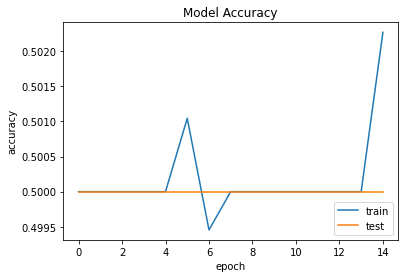

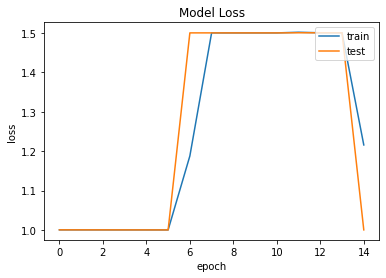

In [24]:
import matplotlib.pyplot as plt

# plot history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

# plot history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [25]:
from sklearn.metrics import classification_report

pred = model.predict(x_test)
print(pred.shape) #the predictions return in one-hot encoding format
pred = np.argmax(pred, axis=1)
print(pred.shape)
y_true = np.argmax(y_test, axis=1)
print(y_test.shape)
print(classification_report(y_true, pred, target_names=directories))

(5512, 2)
(5512,)
(5512, 2)
              precision    recall  f1-score   support

 Parasitized       0.00      0.00      0.00      2756
  Uninfected       0.50      1.00      0.67      2756

    accuracy                           0.50      5512
   macro avg       0.25      0.50      0.33      5512
weighted avg       0.25      0.50      0.33      5512



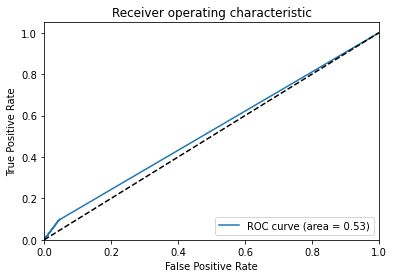

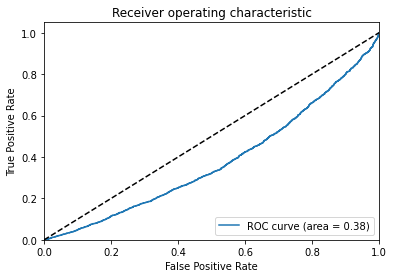

In [26]:
from sklearn.metrics import roc_curve, auc

y_predict = model.predict(x_test) # get the prediction probabilities

false_positive_rate = dict()
true_positive_rate = dict()
roc_auccuracy = dict()
for i in range(num_classes):
    false_positive_rate[i], true_positive_rate[i], _ = roc_curve(y_test[:, i], y_predict[:, i])
    roc_auccuracy[i] = auc(false_positive_rate[i], true_positive_rate[i])
# Plot of a ROC curve for a specific class
for i in range(num_classes):
    plt.figure()
    plt.plot(false_positive_rate[i], true_positive_rate[i], label='ROC curve (area = %0.2f)' % roc_auccuracy[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [27]:
from sklearn.metrics import confusion_matrix

y_pred = np.argmax(y_predict, axis=1)
y_te = np.argmax(y_test, axis=1)
#Generate confusion matrix
cf_matrix = confusion_matrix(y_te, y_pred)

print(cf_matrix)

[[   0 2756]
 [   0 2756]]


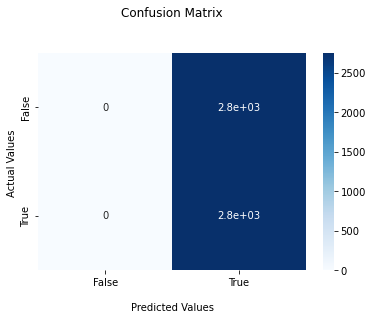

In [28]:
import seaborn as sb

plot = sb.heatmap(cf_matrix, annot=True, cmap='Blues')

plot.set_title('Confusion Matrix\n\n');
plot.set_xlabel('\nPredicted Values')
plot.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
plot.xaxis.set_ticklabels(['False','True'])
plot.yaxis.set_ticklabels(['False','True'])

## Display Confusion Matrix.
plt.show()